<h1 style="text-align: center;">Midterm - Computer Vision (Retinal Disease) <h1>

This is one of two options for the midterm.

This option involves automated pathology detection for medical images. 

We're asking you to develop a solution, using computer vision techniques, that can detect when images of a patient's eye contain evidence of specific medical pathologies. The setup is somewhat realistic in the sense that each image may have multiple pathologies.

The goal, for you as an MLE, is to design models and methods to detect pathological images and explain the pathology sites in the image data.

Your submission should be a single file (either just a .ipynb file or a .zip file--if you use multiple files for any helper functions). Please stay organized and follow the outline of the different tasks that we provide below.

## The data

Data is taken from a Kaggle contest: https://www.kaggle.com/c/vietai-advance-course-retinal-disease-detection/overview

The training data set contains 3,435 retinal images that represent multiple pathological disorders. The pathology classes and corresponding labels are included in the `train.csv` file, and each image can have more than one class (multiple pathologies).

The labels for each image are:

- opacity (0), 
- diabetic retinopathy (1), 
- glaucoma (2),
- macular edema (3),
- macular degeneration (4),
- retinal vascular occlusion (5)
- normal (6)

The test data set contains 350 unlabeled images.

## The tasks

For this assignment, assume you are working with specialists for Diabetic Retinopathy and Glaucoma only, and your client is interested in a predictive learning model that identifies when patients have Diabetic Retinopathy or Glaucoma. They also care if the patient has any other pathology, but not the specific details of which other pathology. That means they want a prediction with 3 (non-exclusive) options:
1. Diabetic Retinopathy
2. Glaucoma
3. Other

The absence of any of these pathologies would be considered Normal.

Your client is also interested in feature explainability and learning with small amounts of data.

**Design models and methods for the following tasks. Each task should be accompanied by**:
* code
* plots/images (if applicable)
* tables (if applicable)
* text explanations (in markdown cells) of what is being done and why

### Task 1: Build a classification model (50 points)
You should perform a random 70/30 data split for training and validation. Report classification metrics (Accuracy, Precision, Recall, F1) on the validation data set. You can choose to apply any data augmentation strategy, but please explain your methods and rationale behind what types of data augmentation you include. We expect you to fit at least **2 different models**, and pick the one you think works best. Getting a good fit for the models should include some amount of basic hyperparameter tuning. Make sure that when you train the models you display training-validation curves to ensure overfitting and underfitting is avoided.

We expect your solution to have at least the following components (point breakdowns for each component indicated)
```
1. Performs basic Exploratory Data Analysis (5 points)
2. Sets up a data augmentation pipeline (10 points)
3. Model Fitting (25 points)
```


The remaining 10 points for this task will be given for the following:
```
4. Addresses the multi-label nature of this data (5 points)
5. F1 score is in the top quartile among all students (5 points)
```

### Task 2: Visualize regions of interest that contribute to Diabetic Retinopathy and Glaucoma (25 points)
We want you to help the client understand what parts of an image are important for making the pathology classification. In support of that, you should visualize the feature activations and generate some saliency heatmaps using any method of your choice. For the saliency heatmap, one suggestion is to apply the gradCAM method, although this is only a suggestion. The point breakdown for this task is:

```
1. Implements feature activation, heatmap visualization (15 points)
2. Provides a written and graphical analysis of these visualizations (10 points)
```
The written analysis of your visualizations should be more than 50 words, but less than 500 words. Describe what you found from doing the feature activation and heatmap visualization on some images with different pathologies. 

### Task 3: Using the unlabeled data set in the `test` folder, augment the training data (semi-supervised learning) and report the change in classification performance on your (labeled) validation data set (15 points)

Here's how we would like to you do to this:
1. Pass the unlabelled images through the trained model and retrieve the dense layer features prior to the classification layer. Using this dense layer as representative of the image, apply label propagation using these features in order to retrieve labels corresponding to the unlabeled data.
2. Next, concatenate the train data with the unlabeled data (that has now been self-labeled) and retrain the network, either from scratch or just fine-tuning, up to you.
3. Report classification performance on the labeled validation data you generated in Task 1

The points breakdown for this task is:
```
1. Correctly grabs the dense layer activations for unlabeled data (2 points)
2. Applies label propagation using the dense layer activations (8 points)
3. Retrains the model using self-labeled data. Reports changes in performance (5 points)
```


### Style and clarity (10 points)
Please attempt to write clear, well-commented code and explanations in markdown cells, where appropriate. The remaining 10 points will be allocated based on how well you do this.



## That's it. Good Luck!

<br>
<br> 
<br>

----

# Setup folders, copy data to local instance, import necessary libraries


In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

import os

# Copy files to local instance
path = '/content/Data/'
isdir = os.path.isdir(path)

os.chdir('/content/')

if not isdir:
  !cp /content/drive/MyDrive/FourthBrain/Final_midterm/Data.zip .
  !unzip -q Data.zip
  !rm Data.zip
  !cp -a /content/Data/test/test/. /content/Data/train/train/

print(f'Files loaded at {path}')

# change pwd
os.chdir('/content/drive/MyDrive/FourthBrain/Final_midterm/')  # you'll have to change this to wherever you stored this notebook
pwd = os.getcwd()
print(f'Current working directory is {pwd}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files loaded at /content/Data/
Current working directory is /content/drive/MyDrive/FourthBrain/Final_midterm


In [ ]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import sys

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, schedules
from tensorflow import keras
import tensorflow as tf

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

from helper_functions import *
from sklearn.semi_supervised import LabelSpreading

In [ ]:
# Install tensorflow addons
try:
  import tensorflow_addons as tfa
except:
  !pip install -U tensorflow-addons
  import tensorflow_addons as tfa

     |████████████████████████████████| 1.1 MB 12.1 MB/s 


# Task 1

## Exploratory data analysis

In [ ]:
# Read labeled data

train = pd.read_csv('/content/Data/train/train.csv')
train.head()

,filename,opacity,diabetic retinopathy,glaucoma,macular edema,macular degeneration,retinal vascular occlusion,normal
0,c24a1b14d253.jpg,0,0,0,0,0,1,0
1,9ee905a41651.jpg,0,0,0,0,0,1,0
2,3f58d128caf6.jpg,0,0,1,0,0,0,0
3,4ce6599e7b20.jpg,1,0,0,0,1,0,0
4,0def470360e4.jpg,1,0,0,0,1,0,0


In [ ]:
# Reduce the no. of labels from 7 to 3

train_red=train.copy(deep=True)

condition = train_red['opacity'] | train_red['macular edema'] | train_red['macular degeneration'] | train_red['retinal vascular occlusion']
train_red['other'] = np.where(condition, 1, 0)

columns=['diabetic retinopathy', 'glaucoma', 'other']

train_red = train_red[['filename'] + columns]
train_red.head()

,filename,diabetic retinopathy,glaucoma,other
0,c24a1b14d253.jpg,0,0,1
1,9ee905a41651.jpg,0,0,1
2,3f58d128caf6.jpg,0,1,0
3,4ce6599e7b20.jpg,0,0,1
4,0def470360e4.jpg,0,0,1


This image has label

diabetic retinopathy    0
glaucoma                0
other                   1
Name: 0, dtype: object

Maximum pixel value in image = 255
Image shape (512, 512, 3)



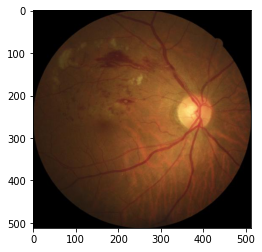

In [ ]:
# plot an image and its label

PATH = '/content/Data'

img = plt.imread(PATH + '/train/train/' + train_red['filename'][0])

plt.imshow(img)
print(f"This image has label")
print('')
print(train_red.iloc[0,1:])
print('')
print(f"Maximum pixel value in image = {np.max(img)}")
print(f'Image shape {img.shape}')
print('')

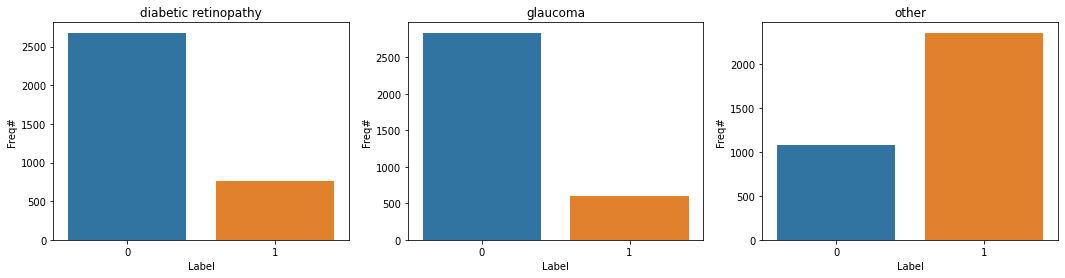

In [ ]:
# Plot histogram of labels
import seaborn as sns

plt.figure(figsize=(18, 4))

for i, col in enumerate(columns):
  plt.subplot(130+(i+1)).set_title(f'{col}')
  ax = sns.countplot(x=train_red[col]);
  ax.set(xlabel="Label", ylabel = "Freq#")

The data seems to be imbalanced, but should be fine. I have tried balancing the data with oversampling and the results weren't significantly different. For the final version, I have trained the model with the data as is.


## Setup Data augmentation pipeline

In [ ]:
# Setup the data generators
batch_size = 32
num_classes = 3
target_size = (224, 224)

from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(train_red, train_size=0.7, random_state=42)

data_gen_args = dict(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

# # Tried these settings, but didnt improve results
# data_gen_args = dict(rotation_range=0.2,
#                     width_shift_range=0.05,
#                     height_shift_range=0.05,
#                     shear_range=0.05,
#                     zoom_range=[0.7,1],
#                     horizontal_flip=True,
#                     fill_mode='nearest')

datagen=ImageDataGenerator(rescale=1./255., **data_gen_args)
test_datagen=ImageDataGenerator(rescale=1./255.)

train_generator=datagen.flow_from_dataframe(
dataframe=df_train,
directory='/content/Data/train/train',
x_col="filename",
y_col=columns,
batch_size=batch_size,
seed=42,
shuffle=True,
class_mode="raw",
target_size=target_size)

valid_generator=test_datagen.flow_from_dataframe(
dataframe=df_val,
directory='/content/Data/train/train',
x_col="filename",
y_col=columns,
batch_size=batch_size,
seed=42,
shuffle=True,
class_mode="raw",
target_size=target_size)

Found 2404 validated image filenames.
Found 1031 validated image filenames.


In [ ]:
# F1 metric
F1_metric = tfa.metrics.F1Score(num_classes=3, threshold=0.5, average='micro')

## ResNet50 as base model

In [ ]:
# Use pre-trained ResNet50 without top layer
base_model = ResNet50(include_top=False, pooling='avg', weights="imagenet", input_shape=(*target_size, 3))

x = base_model.output
predictions = Dense(num_classes, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = True

model.compile(optimizer= Adam(learning_rate=0.0001),
                loss='binary_crossentropy',
                metrics=[F1_metric])

Basic hyper-parameter tuning was performed and a learning rate of 0.0001 was selected as the best.

In [ ]:
# setup callback functions

logdir = "logs_resnet50/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(logdir + "/metrics")
file_writer.set_as_default()

tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('resnet50_finetuned.hdf5', monitor='val_f1_score', mode='max', verbose=1, save_best_only=True)
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_f1_score', mode='max', patience=15)

# Train the model

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

resnet50_training_history = model.fit(x=train_generator,
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_data=valid_generator,
          validation_steps=STEP_SIZE_VALID,
          epochs=100,
          verbose=1,
          callbacks=[model_checkpoint_callback, tensorboard_callback, earlystop_callback]
)

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/100
75/75 [==============================] - 48s 544ms/step - loss: 0.3969 - f1_score: 0.7534 - val_loss: 0.5499 - val_f1_score: 0.6554

Epoch 00001: val_f1_score improved from -inf to 0.65537, saving model to resnet50_finetuned.hdf5
Epoch 2/100
75/75 [==============================] - 39s 524ms/step - loss: 0.2931 - f1_score: 0.8295 - val_loss: 0.6841 - val_f1_score: 0.6566

Epoch 00002: val_f1_score improved from 0.65537 to 0.65665, saving model to resnet50_finetuned.hdf5
Epoch 3/100
75/75 [==============================] - 39s 524ms/step - loss: 0.2348 - f1_score: 0.8664 - val_loss: 0.7883 - val_f1_score: 0.6551

Epoch 00003: val_f1_score did not improve from 0.65665
Epoch 4/100
75/75 [==============================] - 38s 513ms/step - loss: 0.2045 - f1_score: 0.8867 - val_loss: 0.9952 - val_f1_score: 0.6560

Epoch 00004: val_f1_score did not improve from 0.65665
Epoch 5/100
75/75 [==============================] - 39s 513ms/step - loss: 0.1837 - f1_score: 0.9024 - val_loss:

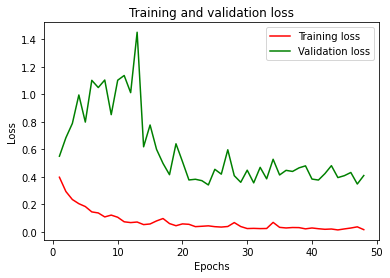

In [ ]:


print_loss_history(resnet50_training_history.history)

Training and validation loss has stabilized and stayed nearly flat after 30 epochs. Epoch 33 was chosen as the final model.

### Test on validation dataset

In [ ]:
model_resnet50=tf.keras.models.load_model('resnet50_finetuned.hdf5')

In [ ]:
# Test performance on val dataset
test_generator=test_datagen.flow_from_dataframe(
dataframe=df_val,
directory='/content/Data/train/train',
x_col="filename",
batch_size=1,
seed=42,
shuffle=False,
class_mode=None,
target_size=target_size)

STEP_SIZE_VALID=test_generator.n//test_generator.batch_size

Found 1031 validated image filenames.


In [ ]:
pred=model_resnet50.predict_generator(test_generator,
steps=STEP_SIZE_VALID,
verbose=1)

y_pred = (pred>0.5).astype(int)
y_true=df_val.iloc[:,1:].to_numpy()

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1031/1031 [==============================] - 12s 11ms/step


#### Performance metrics

In [ ]:
acc, prec, recall, f1 = calc_metrics(y_true, y_pred)

print(f'Accuracy = {round(acc,2)}')
print(f'Precision = {round(prec,2)}')
print(f'Recall = {round(recall,2)}')
print(f'F1 = {round(f1,2)}')

Accuracy = 0.92
Precision = 0.9
Recall = 0.88
F1 = 0.89


## Alexnet as base architecture (from scratch training)

In [ ]:
# Define the AlexNet model [This is given]
#1. Model Definition
class AlexNet(Sequential):
   def __init__(self, input_shape, num_classes):
    super().__init__()

    self.add(Conv2D(96, kernel_size=(11,11), strides= 4,
                    padding= 'valid', activation= 'relu',
                    input_shape= input_shape, kernel_initializer= 'he_normal'))
    self.add(BatchNormalization())
    self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                          padding= 'valid', data_format= None))
    
    
    self.add(Conv2D(256, kernel_size=(5,5), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= 'he_normal'))
    self.add(BatchNormalization())
    self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                          padding= 'valid', data_format= None)) 
    

    self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= 'he_normal'))
    self.add(BatchNormalization())
    
    self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= 'he_normal'))
    self.add(BatchNormalization())
    
    self.add(Conv2D(256, kernel_size=(3,3), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= 'he_normal'))
    self.add(BatchNormalization())
    
    self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                          padding= 'valid', data_format= None))
    

    self.add(Flatten())
    
    self.add(Dense(num_classes, activation= 'sigmoid'))

    self.compile(optimizer= Adam(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=[F1_metric]
)

In [ ]:
# Instantiate the model and summary
input_shape = (*target_size, 3)
model_alex = AlexNet(input_shape, num_classes)

In [ ]:
# Train the model
train_generator.reset()
valid_generator.reset()

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('alexnet.hdf5', monitor='val_f1_score', mode='max', verbose=1, save_best_only=True)
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_f1_score', mode='max', patience=15)

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

alexnet_training_history = model_alex.fit(x=train_generator,
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_data=valid_generator,
          validation_steps=STEP_SIZE_VALID,
          epochs=100,
          verbose=1,
          callbacks=[model_checkpoint_callback, earlystop_callback]
)

Epoch 1/100
75/75 [==============================] - 34s 447ms/step - loss: 0.7169 - f1_score: 0.6455 - val_loss: 1.2693 - val_f1_score: 0.6573

Epoch 00001: val_f1_score improved from -inf to 0.65728, saving model to alexnet.hdf5
Epoch 2/100
75/75 [==============================] - 33s 447ms/step - loss: 0.5670 - f1_score: 0.6549 - val_loss: 1.7082 - val_f1_score: 0.6557

Epoch 00002: val_f1_score did not improve from 0.65728
Epoch 3/100
75/75 [==============================] - 33s 446ms/step - loss: 0.5343 - f1_score: 0.6643 - val_loss: 0.9983 - val_f1_score: 0.6170

Epoch 00003: val_f1_score did not improve from 0.65728
Epoch 4/100
75/75 [==============================] - 33s 443ms/step - loss: 0.5688 - f1_score: 0.6518 - val_loss: 0.5327 - val_f1_score: 0.6726

Epoch 00004: val_f1_score improved from 0.65728 to 0.67262, saving model to alexnet.hdf5
Epoch 5/100
75/75 [==============================] - 34s 448ms/step - loss: 0.5733 - f1_score: 0.6561 - val_loss: 0.9938 - val_f1_score

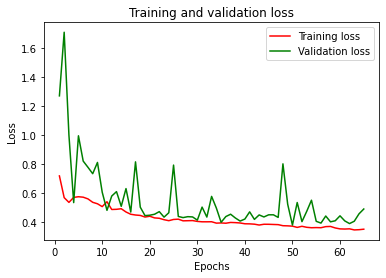

In [ ]:
print_loss_history(alexnet_training_history.history)

Training ended with an early stop. Epoch 50 was selected as the final model.

### Test on validation dataset

In [ ]:
# Test performance on val dataset
test_generator.reset()

pred=model_alex.predict_generator(test_generator,
steps=STEP_SIZE_VALID,
verbose=1)

y_pred = (pred>0.5).astype(int)
y_true = df_val.iloc[:,1:].to_numpy()

#### Performance metrics

In [ ]:
acc, prec, recall, f1 = calc_metrics(y_true, y_pred)

print(f'Accuracy = {round(acc,2)}')
print(f'Precision = {round(prec,2)}')
print(f'Recall = {round(recall,2)}')
print(f'F1 = {round(f1,2)}')

## Final Selected Model

Based on the model performance of AlexNet and ResNet50, ReNet50 was selected as the final model for the remaining tasks.

# Task 2

In [ ]:
import cv2
from google.colab.patches import cv2_imshow 
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K

In [ ]:
model_resnet50.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
def grad_cam(fname, model):
  DIM = 224

  img = image.load_img(fname, target_size=(DIM, DIM))
  x = image.img_to_array(img)/255.
  x = np.expand_dims(x, axis=0)

  preds = model.predict(x)
  pred_bool = (preds>0.5).astype(int).ravel()

  print(f"This image has label")
  print('')
  print(f'Diabetic retinopathy  {pred_bool[0]}')
  print(f'Glaucoma              {pred_bool[1]}')
  print(f'Other                 {pred_bool[2]}')

  with tf.GradientTape() as tape:
    last_conv_layer = model.get_layer('conv5_block3_out')
    iterate = tf.keras.models.Model([model.input], [model.output, last_conv_layer.output])
    model_out, last_conv_layer = iterate(x)
    class_out = model_out[:, np.argmax(model_out[0])]
    grads = tape.gradient(class_out, last_conv_layer)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
  heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)

  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = heatmap.reshape((7, 7))
  plt.matshow(heatmap)
  plt.show()

  img = cv2.imread(fname)

  INTENSITY = 0.5
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
  img1 = heatmap * INTENSITY + img

  cv2_imshow(cv2.resize(img, (300, 300)))
  cv2_imshow(cv2.resize(img1, (300, 300)))

In [ ]:
# Activations

layer_outputs = [layer.output for layer in model_resnet50.layers]

activation_model = Model(inputs=model_resnet50.input, outputs=layer_outputs)

## Galucoma example

### GradCam saliency map

This image has label

Diabetic retinopathy  0
Glaucoma              1
Other                 0


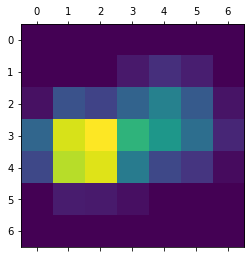

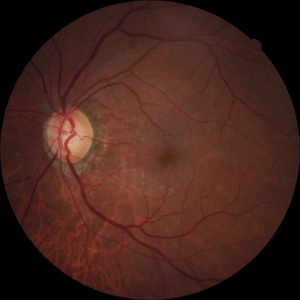

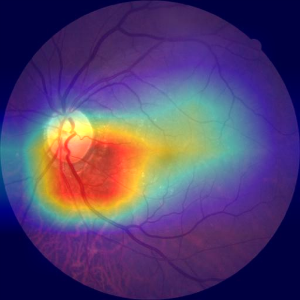

In [ ]:
fname = '/content/Data/train/train/338d390b0d66.jpg'
grad_cam(fname, model_resnet50)

### Activation maps last conv layer

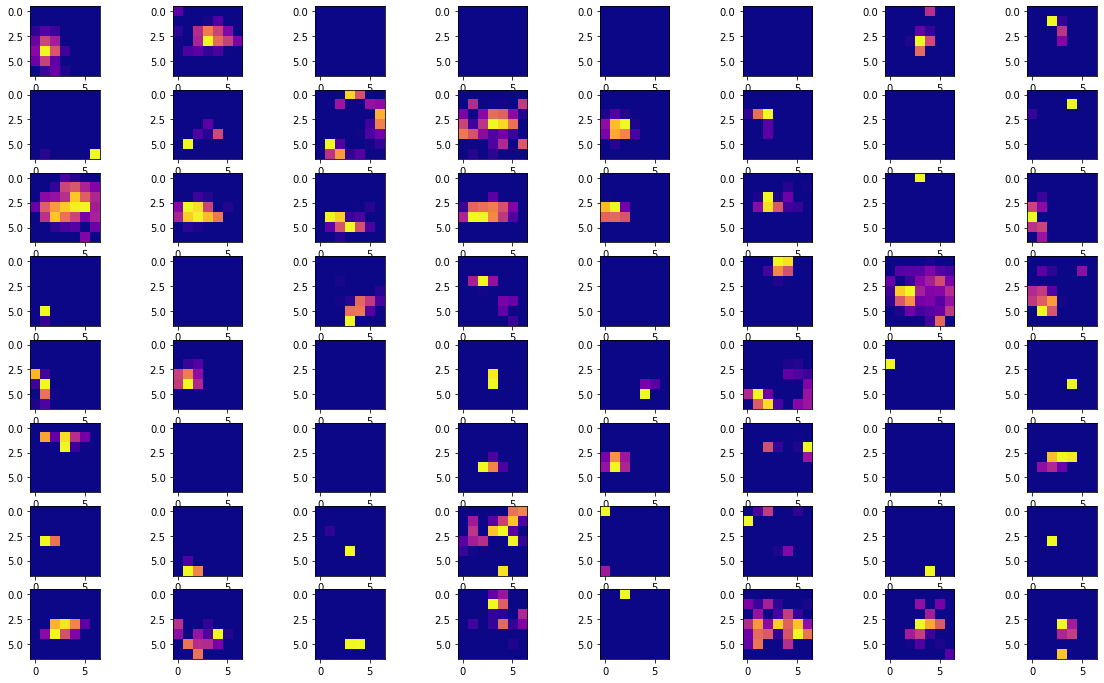

In [ ]:
DIM = 224
img = image.load_img(fname, target_size=(DIM, DIM))
x = image.img_to_array(img)/255.
x = np.expand_dims(x, axis=0)

activations = activation_model.predict(x)

display_activation(activations, 8, 8, -3)

## Diabetic retinopathy example

### GradCam saliency map 

This image has label

Diabetic retinopathy  1
Glaucoma              0
Other                 0


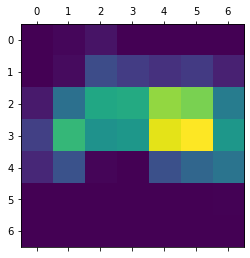

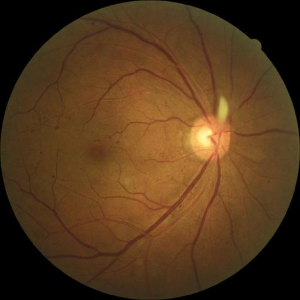

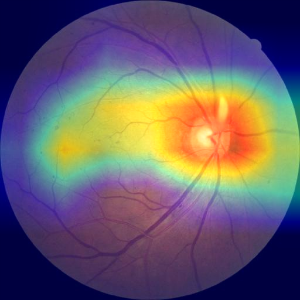

In [ ]:
fname = '/content/Data/train/train/6ef741ba4c43.jpg'
grad_cam(fname, model_resnet50)

### Activation maps last conv layer

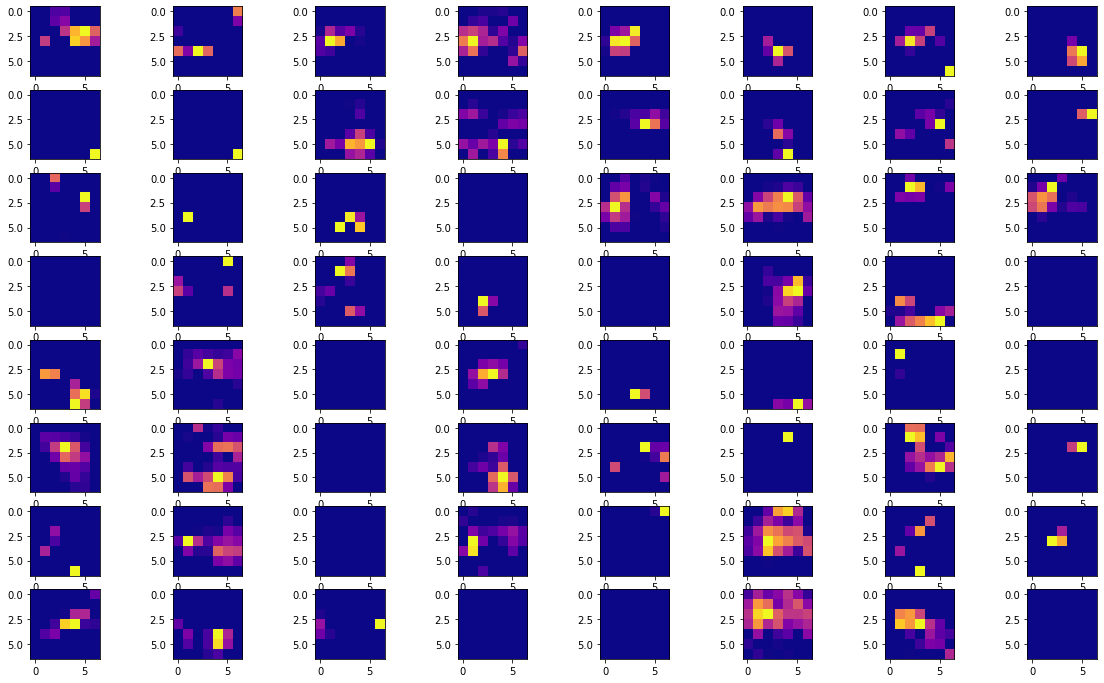

In [ ]:
DIM = 224
img = image.load_img(fname, target_size=(DIM, DIM))
x = image.img_to_array(img)/255.
x = np.expand_dims(x, axis=0)

activations = activation_model.predict(x)

display_activation(activations, 8, 8, -3)

## Other example

### GradCam saliency map

This image has label

Diabetic retinopathy  0
Glaucoma              0
Other                 1


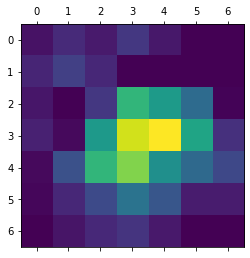

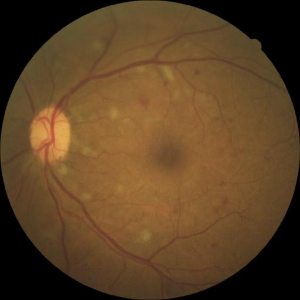

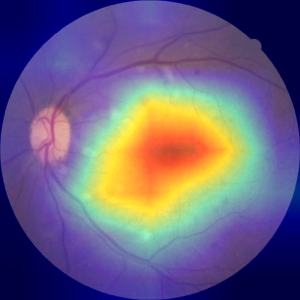

In [ ]:
fname = '/content/Data/train/train/e98b19a472b0.jpg'
grad_cam(fname, model_resnet50)

### Activation maps last conv layer

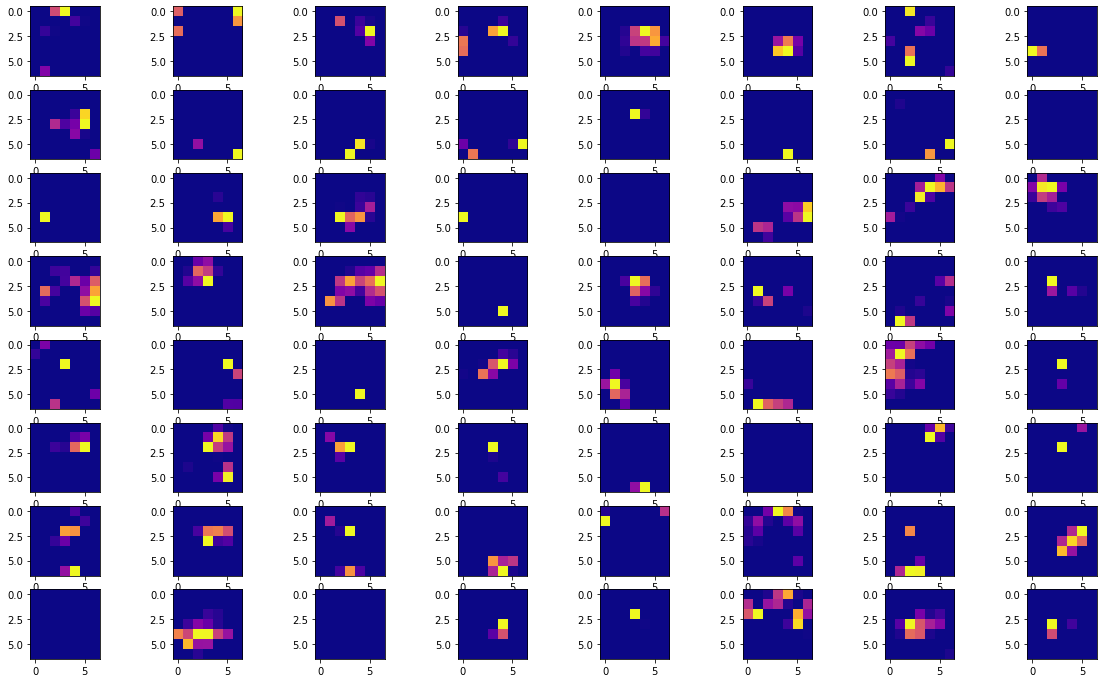

In [ ]:
DIM = 224
img = image.load_img(fname, target_size=(DIM, DIM))
x = image.img_to_array(img)/255.
x = np.expand_dims(x, axis=0)

activations = activation_model.predict(x)

display_activation(activations, 8, 8, -3)

## Written Analysis

If we look at the GradCam saliency maps, it shows the regions of interest for the model which making the image classification. In the Galucoma example, the model was focusing on the optic disc area and how it was distorted compared to a normal case. And therefore, classfying as Glaucoma. In the second example (diabetic retinopathy), it sees the rupture near the optic disc. In the third example, it was identifying the white spots scattered around the image. As we also look at the activation maps of the las convolution layer, we can see that the model is trying to detect higher level features and patterns around the image.

# Task 3

Encoder model

In [ ]:
# Extract the last layer before the classification head

last_before_layer = model_resnet50.get_layer('avg_pool')
encoder = tf.keras.models.Model([model_resnet50.input], [last_before_layer.output])

In [ ]:
# Create test dataset df with filenames
dir_list = os.listdir('/content/Data/test/test/')
test = pd.DataFrame(dir_list,columns=['filename'])
test.sort_values(by=['filename'], inplace=True)

In [ ]:
# Run test data through the model

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory='/content/Data/test/test',
x_col="filename",
batch_size=1,
seed=42,
shuffle=False,
class_mode=None,
target_size=target_size)

STEP_SIZE_VALID=test_generator.n//test_generator.batch_size

test_features=encoder.predict_generator(test_generator,
steps=STEP_SIZE_VALID,
verbose=1)

Found 350 validated image filenames.


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


350/350 [==============================] - 5s 11ms/step


In [ ]:
# Run Train+val data through the model

test_generator=test_datagen.flow_from_dataframe(
dataframe=train_red,
directory='/content/Data/train/train',
x_col="filename",
batch_size=1,
seed=42,
shuffle=False,
class_mode=None,
target_size=target_size)

STEP_SIZE_VALID=test_generator.n//test_generator.batch_size

train_features=encoder.predict_generator(test_generator,
steps=STEP_SIZE_VALID,
verbose=1)

Found 3435 validated image filenames.
  10/3435 [..............................] - ETA: 42s

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


3435/3435 [==============================] - 38s 11ms/step


## Label the test data

In [ ]:
# Label the test data through label propagation and append to train data

full_features=np.vstack((train_features, test_features))

test_labeled = test.copy(deep=True)
predicted_labels=np.zeros((350,3))

for i in range(3):
  y_train=train_red.iloc[:,i+1].to_numpy()
  y_full=np.hstack((y_train,np.full(350,-1)))

  # Initialize the model
  lp_model = LabelSpreading(gamma=0.25, max_iter=20)

  # Train the label prop model and generate pseudo labels
  lp_model.fit(full_features,y_full)
  test_labeled[columns[i]] = lp_model.transduction_[3435:]

self_labeled = df_train.append(test_labeled)

/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


## Fine-tune the model with additional labeled data

In [ ]:
model_ss=tf.keras.models.load_model('resnet50_finetuned.hdf5')

In [ ]:
datagen=ImageDataGenerator(rescale=1./255., **data_gen_args)
test_datagen=ImageDataGenerator(rescale=1./255.)

train_generator=datagen.flow_from_dataframe(
dataframe=self_labeled,
directory='/content/Data/train/train',
x_col="filename",
y_col=columns,
batch_size=batch_size,
seed=42,
shuffle=True,
class_mode="raw",
target_size=target_size)

valid_generator=test_datagen.flow_from_dataframe(
dataframe=df_val,
directory='/content/Data/train/train',
x_col="filename",
y_col=columns,
batch_size=batch_size,
seed=42,
shuffle=True,
class_mode="raw",
target_size=target_size)

Found 2754 validated image filenames.
Found 1031 validated image filenames.


In [ ]:
# Train the model
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('resnet50_finetuned_selflabel.hdf5', monitor='val_f1_score', mode='max', verbose=1, save_best_only=True)
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_f1_score', mode='max', patience=15)

training_history = model_ss.fit(x=train_generator,
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_data=valid_generator,
          validation_steps=STEP_SIZE_VALID,
          epochs=100,
          verbose=1,
          callbacks=[model_checkpoint_callback, earlystop_callback]
)

Epoch 1/100
86/86 [==============================] - 48s 515ms/step - loss: 0.0869 - f1_score: 0.9642 - val_loss: 0.3522 - val_f1_score: 0.8434

Epoch 00001: val_f1_score improved from -inf to 0.84337, saving model to resnet50_finetuned_selflabel.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
86/86 [==============================] - 44s 507ms/step - loss: 0.0600 - f1_score: 0.9746 - val_loss: 0.3496 - val_f1_score: 0.8669

Epoch 00002: val_f1_score improved from 0.84337 to 0.86688, saving model to resnet50_finetuned_selflabel.hdf5
Epoch 3/100
86/86 [==============================] - 44s 512ms/step - loss: 0.0444 - f1_score: 0.9792 - val_loss: 0.5290 - val_f1_score: 0.8510

Epoch 00003: val_f1_score did not improve from 0.86688
Epoch 4/100
86/86 [==============================] - 43s 504ms/step - loss: 0.0369 - f1_score: 0.9822 - val_loss: 0.4380 - val_f1_score: 0.8648

Epoch 00004: val_f1_score did not improve from 0.86688
Epoch 5/100
86/86 [==============================] - 43s 504ms/step - loss: 0.0322 - f1_score: 0.9856 - val_loss: 0.5154 - val_f1_score: 0.8220

Epoch 00005: val_f1_score did not improve from 0.86688
Epoch 6/100
86/86 [==============================] - 43s 510ms/step - loss: 0.0665 - f1_score: 0.9692 - val_loss: 0.4661 - val_f1_score: 0.8006



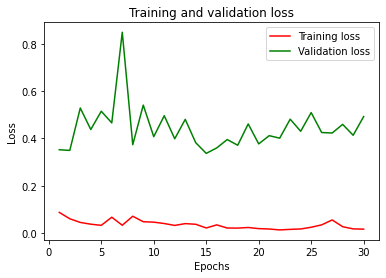

In [ ]:
print_loss_history(training_history.history)

## Classification performance of the semi-supervised method

In [ ]:
# Test performance on val dataset
test_generator=test_datagen.flow_from_dataframe(
dataframe=df_val,
directory='/content/Data/train/train',
x_col="filename",
batch_size=1,
seed=42,
shuffle=False,
class_mode=None,
target_size=target_size)

STEP_SIZE_VALID=test_generator.n//test_generator.batch_size

Found 1031 validated image filenames.


In [ ]:
model_ss=tf.keras.models.load_model('resnet50_finetuned_selflabel.hdf5')

In [ ]:
pred=model_ss.predict_generator(test_generator,
steps=STEP_SIZE_VALID,
verbose=1)

y_pred = (pred>0.5).astype(int)
y_true=df_val.iloc[:,1:].to_numpy()

acc, prec, recall, f1 = calc_metrics(y_true, y_pred)

print(f'Accuracy = {round(acc,2)}')
print(f'Precision = {round(prec,2)}')
print(f'Recall = {round(recall,2)}')
print(f'F1 = {round(f1,2)}')

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1031/1031 [==============================] - 12s 11ms/step
Accuracy = 0.93
Precision = 0.9
Recall = 0.89
F1 = 0.9


Little improvement is seen after adding the pseudo labeled dataset.